In [1]:
import geopandas as gpd
import osmnx as ox
import pandas as pd
import folium

In [2]:
# import lodes dataset

lodes=pd.read_csv('../../../Research with Geoff/la-emissions-master/analysis/data/input/Lodes/ca_od_main_JT00_2017.csv',
                 dtype={'w_geocode' : str, 'h_geocode':str})

lodes.head()

In [4]:
# import la neighborhood shapefile from LA Times - limit to expo park nh
la_hoods=gpd.read_file('data/lahoods')
expo=la_hoods[la_hoods['name']=='Exposition Park']

In [5]:
# import census block neighborhoods
blocks=gpd.read_file('data/blocks_shapefile10')

In [6]:
# import tracts
tracts=gpd.read_file('data/tl_2010_06037_tract10')

# drop the channel islands' tracts
islands = {'06037599100', '06037599000','06037990100','06037990200','06037990300'}
mask = ~tracts['GEOID10'].isin(islands)
tracts = tracts[mask]

In [7]:
# import cities and remove islands

cities=gpd.read_file('data/LA_County_City_Boundaries')

remove=list(cities.cx[:,:33.55]['OBJECTID'])
cities=cities[~cities['OBJECTID'].isin(remove)]


In [8]:
#align all crs's

crs=blocks.crs
utm = '+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '

expo.to_crs(utm, inplace=True)
blocks.to_crs(utm, inplace=True)
tracts.to_crs(utm, inplace=True)
la_hoods.to_crs(utm, inplace=True)
cities.to_crs(utm, inplace=True)
expo.crs==blocks.crs==tracts.crs==la_hoods.crs==cities.crs

/Users/petermannino/anaconda3/envs/la_emissions/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


True

In [9]:
# identify the census blocks that are located in expo park

# generate block centroids
blocks['center']=blocks.centroid
blocks.set_geometry('center', inplace=True)

# sjoin to identify blocks by identifying which block centroids are within the expo park polygon
expo_blocks_gdf=gpd.sjoin(blocks, expo, how='inner', op='intersects')

# reset blocks geometry
expo_blocks_gdf.set_geometry('geometry', inplace=True)
blocks.set_geometry('geometry', inplace=True)

#generate list of block geoids in expo park neighborhod
expo_blocks=list(expo_blocks_gdf['GEOID10'])

In [10]:
# from lodes data, identify which people live in expo park and which work in expo park

live_in_expo=lodes[lodes['h_geocode'].isin(expo_blocks)]
work_in_expo=lodes[lodes['w_geocode'].isin(expo_blocks)]

In [11]:
%%time
# Load the LA county street network graph
la_street_g=ox.load_graphml('/Users/petermannino/Documents/School/Research with Geoff/la-emissions-master/analysis/data/la-county-network-projected.graphml')

CPU times: user 1min 21s, sys: 1min 2s, total: 2min 24s
Wall time: 2min 40s


In [21]:
# create geodataframe of graph edges

gdf_edges = ox.graph_to_gdfs(la_street_g, nodes=False)

## Where people who live in Expo Park, work.

In [12]:
# identify which block that everyone who lives in expo park, works in

live_in_expo_gdf=pd.merge(blocks,live_in_expo[['w_geocode','S000']], how='inner', left_on='GEOID10', right_on='w_geocode')

# set geometry to the block centroid
live_in_expo_gdf.set_geometry('center',inplace=True)

In [13]:
# create la county outline
county=gpd.GeoSeries(tracts.unary_union)

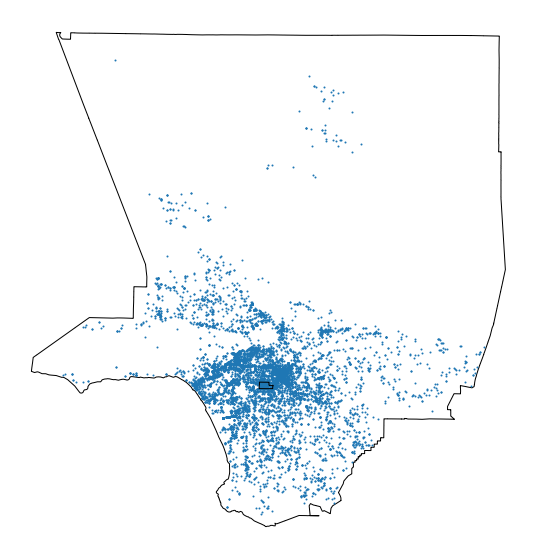

In [14]:
# map the block centroids that have at least one person from expo park working there

# County outline
ax=county.plot(color='white', edgecolor='black',figsize=(12,10))

# the centroid points
live_in_expo_gdf.plot(markersize=1, ax=ax)

# show the expo park neighborhood
expo.plot(color='none', edgecolor='black', ax=ax) 

ax.set_axis_off()

## Where people who work in Expo Park, live.

In [15]:
# identify the blocks that everyone who works in expo, lives in

work_in_expo_gdf=pd.merge(blocks, work_in_expo[['h_geocode','S000']], how='inner', left_on='GEOID10', right_on='h_geocode')

# generate the centroids
work_in_expo_gdf.set_geometry('center',inplace=True,)

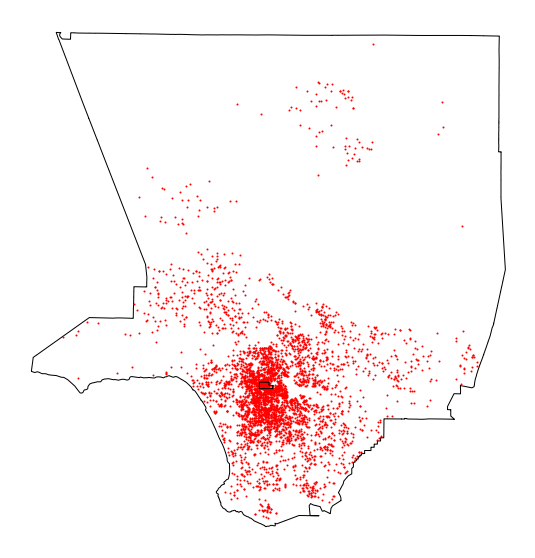

In [16]:
# map the home blocks of everyone who works in expo

# county outline
ax=county.plot(color='white', edgecolor='black',figsize=(12,10))

# block points
work_in_expo_gdf.plot(markersize=1, ax=ax, color='red')

# expo neighborhood
expo.plot(color='none', edgecolor='black', ax=ax)

ax.set_axis_off()

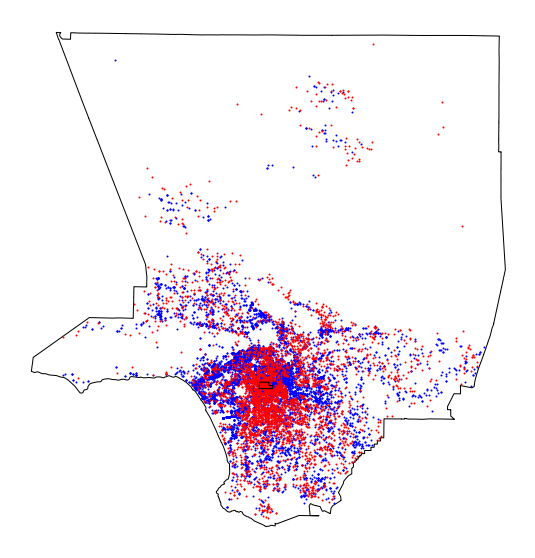

In [17]:
# combine the two maps

# county
ax=county.plot(color='white', edgecolor='black',figsize=(12,10))

# live and work points
live_in_expo_gdf.plot(markersize=1, ax=ax, color='blue')
work_in_expo_gdf.plot(markersize=1, ax=ax, color='red')

# expo
expo.plot(color='none', edgecolor='black', ax=ax)
ax.set_axis_off()

## Commuting to expo
Simulate commute paths to Expo Park neighborhood and map

In [19]:
# set geoid as index
blocks.set_index('GEOID10', inplace=True)

In [120]:
# use the home and work block centroids to find the nearst origin and destination nodes from the la county street graph

# limit origin and destination blocks to only those in la county
mask1=work_in_expo['h_geocode'].isin(list(blocks.index))
mask2=work_in_expo['w_geocode'].isin(list(blocks.index))                                  
work_in_expo_rd=work_in_expo[mask1 & mask2]

# get list of home and work centroids for every o-d pair in the works in expo lodes data
home_centroids=blocks.loc[work_in_expo_rd['h_geocode'].values, 'geometry'].centroid
work_centroids=blocks.loc[work_in_expo_rd['w_geocode'].values, 'geometry'].centroid

# get the origin and destination nodes for every o-d pair in the works in expo lodes data
origs = ox.get_nearest_nodes(la_street_g, home_centroids.x, home_centroids.y, method='kdtree')
dests = ox.get_nearest_nodes(la_street_g, work_centroids.x, work_centroids.y, method='kdtree')

In [125]:
# create a shortest path function that takes origin and destination nodes and returns a route line string from the
# la county street graph gdf, created earlier

def shortest_path(orig, dest):
    try:
        route = ox.shortest_path(la_street_g, orig, dest, weight='travel_time')
        u = route[:-1]
        v = route[1:]
        key = [0] * len(u)
        return gdf_edges.loc[zip(u, v, key), 'geometry'].unary_union
    except:
        # for unsolvable routes (due to directed graph perimeter effects)
        return None

In [126]:
# find all route line strings in list comprehension
paths=[shortest_path(i,j) for i,j in zip(origs,dests)]

In [127]:
# reset index
work_in_expo_rd.reset_index(inplace=True,drop=True)

In [128]:
# merge route strings back into lodes work in expo df - convert to gdf

work_in_expo_rd['routes']= gpd.GeoSeries(paths)
work_in_expo_rd=gpd.GeoDataFrame(work_in_expo_rd, geometry='routes',crs=utm)

#change crs to lat-lon to plot with folium
work_in_expo_rd=work_in_expo_rd.to_crs(epsg=4326)

<ipython-input-128-8a6a30f18a96>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_in_expo_rd['routes']= gpd.GeoSeries(paths)


In [129]:
# convert expo neighborhood outline to lat-long for folium
expo=expo.to_crs(epsg=4326)

In [173]:
# plot routes with folium

# initialize basemap
m=folium.Map(location=(34.0522,-118.2437),tiles='Stamen Toner')

# create simplified route and expo outline geometries
simp_geo=work_in_expo_rd['routes'].simplify(tolerance=.001)
sim_exp=expo['geometry'].simplify(tolerance=.001)

# convert route and expo geometries to json
exp_json=sim_exp.to_json()
simp_json=simp_geo.to_json()

# create folium geojson objects for routes and expo nh and add to map
folium.GeoJson(simp_json,
              lambda x: {'color': '#ff0000',
                        'opacity' : .15,}).add_to(m)

folium.GeoJson(exp_json,
              lambda x: {'color': '#000000',
                         'fill' : True,
                        'fillOpacity' : .2}).add_to(m)
# Display map
# m



In [159]:
# save map
m.save('routes.html')